# RNN for Time Series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import rnn

## Load sample Time Series

In [2]:
df = pd.read_csv('../datasets/international-airline-passengers.csv')
data = df['Passengers']
normalized_data = (data - np.mean(data)) / np.std(data)
normalized_data.head()
# Split to train and test
pos = int(0.8 * len(normalized_data))
train_data = normalized_data[:pos].as_matrix()
test_data = normalized_data[pos:].as_matrix()

## Build class for TS prediction

We are working with multivariate input series and univariate output series. **input_dim** is dimension of single point. The output_dim is 1.

In [21]:
class SeriesPredictor:
    
    def __init__(self, input_dim, seq_size, hidden_dim=10):
        tf.get_variable_scope().reuse_variables()
        self.input_dim = input_dim
        self.seq_size = seq_size
        self.hidden_dim = hidden_dim
        self.x = tf.placeholder(tf.float32, [None, seq_size, input_dim])
        self.y = tf.placeholder(tf.float32, [None, seq_size])
        self.W_out = tf.Variable(tf.random_normal([hidden_dim, 1]), name='W_out')
        self.b_out = tf.Variable(tf.random_normal([1]), name='b_out')
        
        self.cost = tf.reduce_mean(tf.square(self.model() - self.y))
        self.train_op = tf.train.GradientDescentOptimizer(0.001).minimize(self.cost)
        
        self.saver = tf.train.Saver()
        
        
    def model(self):
        cell = rnn.BasicLSTMCell(self.hidden_dim, reuse=tf.get_variable_scope().reuse)
        outputs, states = tf.nn.dynamic_rnn(cell, self.x, dtype=tf.float32)
        num_examples = tf.shape(self.x)[0]
        W_repeated = tf.tile(tf.expand_dims(self.W_out, 0), [num_examples, 1, 1])
        out = tf.matmul(outputs, W_repeated) + self.b_out
        return tf.squeeze(out)
        
        
    def train(self, train_x, train_y):
        with tf.Session() as sess:
#             tf.get_variable_scope().reuse_variables()
            sess.run(tf.global_variables_initializer())
            for i in range(10000):
                _, mse = sess.run([self.train_op, self.cost], feed_dict={self.x: train_x, self.y: train_y})
                if i % 1000 == 0:
                    print(i, mse)
            self.saver.save(sess, '../models/rnn2.ckpt')
    
    
    def test(self, sess, test_x):
#         tf.get_variable_scope().reuse_variables()
        self.saver.restore(sess, '../models/rnn2.ckpt')
        output = sess.run(self.model(), feed_dict={self.x: test_x})
        return output

## Test

In [24]:
def plot_results(train_x, predictions, actual):
    num_train = len(train_x)
    plt.plot(list(range(num_train)), train_x, color='b', label='training data')
    plt.plot(list(range(num_train, num_train + len(predictions))), predictions, color='r', label='predicted')
    plt.plot(list(range(num_train, num_train + len(actual))), actual, color='g', label='test data')
    plt.legend(loc='upper left')
    plt.show()

0 0.684168
1000 0.0905847
2000 0.074632
3000 0.0702582
4000 0.0682631
5000 0.0669077
6000 0.0658217
7000 0.0648863
8000 0.0640491
9000 0.0632824
INFO:tensorflow:Restoring parameters from ../models/rnn2.ckpt
predicted_vals (23,)


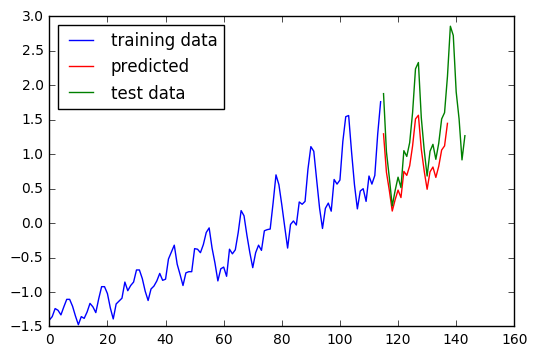

In [26]:
seq_size = 5
predictor = SeriesPredictor(input_dim=1, seq_size=seq_size, hidden_dim=100)

# Prepare training data
train_x, train_y = [], []
for i in range(len(train_data) - seq_size -1):
    train_x.append(np.expand_dims(train_data[i:i+seq_size], axis=1).tolist())
    train_y.append(train_data[i+1:i+seq_size+1].tolist())

# Prepare test data
test_x, test_y = [], []
for i in range(len(test_data) - seq_size -1):
    test_x.append(np.expand_dims(test_data[i:i+seq_size], axis=1).tolist())
    test_y.append(test_data[i+1:i+seq_size+1].tolist())

predictor.train(train_x, train_y)

with tf.Session() as sess:
    predicted_vals = predictor.test(sess, test_x)[:,0]
    print('predicted_vals', np.shape(predicted_vals))
    plot_results(train_data, predicted_vals, test_data)
